## Results
We evaluate the model using classification metrics and explain predictions using SHAP.


## Methodology
1. Data loading and exploration
2. Feature engineering and labeling
3. Model training using Random Forest
4. Model evaluation
5. Model explainability using SHAP


## Dataset Overview
We use the NASA C-MAPSS turbofan engine degradation dataset, which contains
sensor readings collected over multiple operational cycles.


## Problem Statement
The goal of this project is to predict whether an aircraft engine is likely to fail soon
using historical sensor data. This enables predictive maintenance and improves safety.


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline



In [3]:
columns = [
    'engine_id',
    'cycle',
    'op_setting_1',
    'op_setting_2',
    'op_setting_3'
] + [f'sensor_{i}' for i in range(1, 22)]


In [4]:
df = pd.read_csv(
    '../data/raw/train_FD001.txt',
    sep=' ',
    header=None,
    names=columns
)

# Remove extra empty columns (caused by spacing)
df = df.dropna(axis=1)


In [5]:
df.shape


(20631, 24)

In [6]:
df.head()

engine_id   cycle  op_setting_1  op_setting_2  op_setting_3  sensor_1  \
1 1    -0.0007 -0.0004         100.0        518.67        641.82   1589.70   
  2     0.0019 -0.0003         100.0        518.67        642.15   1591.82   
  3    -0.0043  0.0003         100.0        518.67        642.35   1587.99   
  4     0.0007  0.0000         100.0        518.67        642.35   1582.79   
  5    -0.0019 -0.0002         100.0        518.67        642.37   1582.85   

     sensor_2  sensor_3  sensor_4  sensor_5  ...  sensor_10  sensor_11  \
1 1   1400.60     14.62     21.61    554.36  ...     521.66    2388.02   
  2   1403.14     14.62     21.61    553.75  ...     522.28    2388.07   
  3   1404.20     14.62     21.61    554.26  ...     522.42    2388.03   
  4   1401.87     14.62     21.61    554.45  ...     522.86    2388.08   
  5   1406.22     14.62     21.61    554.00  ...     522.19    2388.04   

     sensor_12  sensor_13  sensor_14  sensor_15  sensor_16  sensor_17  \
1 1    8138.62     8.4195       0.03        392       2388      100.0   
  2    8131.49     8.4318       0.03        392       2388      100.0   
  3    8133.23     8.4178       0.03        390       2388      100.0   
  4    8133.83     8.3682       0.03        392       2388      100.0   
  5    8133.80     8.4294       0.03        393       2388      100.0   

     sensor_18  sensor_19  
1 1      39.06    23.4190  
  2      39.00    23.4236  
  3      38.95    23.3442  
  4      38.88    23.3739  
  5      38.90    23.4044  

[5 rows x 24 columns]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 20631 entries, (np.int64(1), np.int64(1)) to (np.int64(100), np.int64(200))
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   engine_id     20631 non-null  float64
 1   cycle         20631 non-null  float64
 2   op_setting_1  20631 non-null  float64
 3   op_setting_2  20631 non-null  float64
 4   op_setting_3  20631 non-null  float64
 5   sensor_1      20631 non-null  float64
 6   sensor_2      20631 non-null  float64
 7   sensor_3      20631 non-null  float64
 8   sensor_4      20631 non-null  float64
 9   sensor_5      20631 non-null  float64
 10  sensor_6      20631 non-null  float64
 11  sensor_7      20631 non-null  float64
 12  sensor_8      20631 non-null  float64
 13  sensor_9      20631 non-null  float64
 14  sensor_10     20631 non-null  float64
 15  sensor_11     20631 non-null  float64
 16  sensor_12     20631 non-null  float64
 17  sensor_13     20631

In [8]:
df.isnull().sum()

engine_id       0
cycle           0
op_setting_1    0
op_setting_2    0
op_setting_3    0
sensor_1        0
sensor_2        0
sensor_3        0
sensor_4        0
sensor_5        0
sensor_6        0
sensor_7        0
sensor_8        0
sensor_9        0
sensor_10       0
sensor_11       0
sensor_12       0
sensor_13       0
sensor_14       0
sensor_15       0
sensor_16       0
sensor_17       0
sensor_18       0
sensor_19       0
dtype: int64

In [9]:
df['engine_id'].nunique()

158

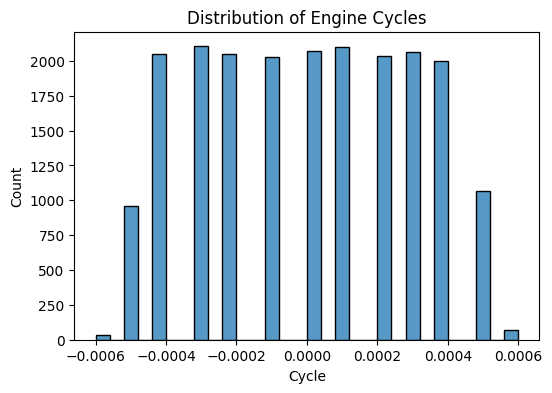

In [10]:
plt.figure(figsize=(6, 4))
sns.histplot(df['cycle'], bins=30)
plt.title("Distribution of Engine Cycles")
plt.xlabel("Cycle")
plt.ylabel("Count")
plt.show()


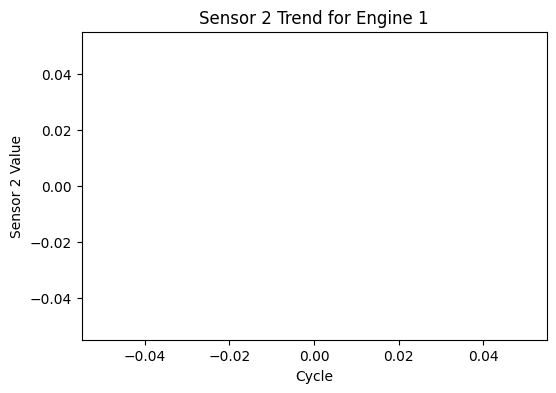

In [11]:
engine_1 = df[df['engine_id'] == 1]

plt.figure(figsize=(6, 4))
plt.plot(engine_1['cycle'], engine_1['sensor_2'])
plt.xlabel("Cycle")
plt.ylabel("Sensor 2 Value")
plt.title("Sensor 2 Trend for Engine 1")
plt.show()


In [12]:
# Step 1: Find the maximum cycle for each engine
max_cycles = df.groupby('engine_id')['cycle'].max().reset_index()
max_cycles.columns = ['engine_id', 'max_cycle']

max_cycles.head()


,engine_id,max_cycle
0,-0.0087,-0.0001
1,-0.0086,-0.0001
2,-0.0084,0.0005
3,-0.0081,0.0004
4,-0.0078,-0.0004


In [13]:
# Merge max cycle back to original dataframe
df = df.merge(max_cycles, on='engine_id')

# Calculate RUL
df['RUL'] = df['max_cycle'] - df['cycle']

df[['engine_id', 'cycle', 'RUL']].head()


,engine_id,cycle,RUL
0,-0.0007,-0.0004,0.0010
1,0.0019,-0.0003,0.0009
2,-0.0043,0.0003,0.0002
3,0.0007,0.0000,0.0005
4,-0.0019,-0.0002,0.0007


In [14]:
# Define failure threshold
FAILURE_THRESHOLD = 30

# Create binary target column
df['fail_soon'] = np.where(df['RUL'] <= FAILURE_THRESHOLD, 1, 0)

df[['RUL', 'fail_soon']].head(10)


,RUL,fail_soon
0,0.0010,1
1,0.0009,1
2,0.0002,1
3,0.0005,1
4,0.0007,1
5,0.0006,1
6,0.0004,1
7,0.0003,1
8,0.0005,1
9,0.0004,1


In [15]:
df['fail_soon'].value_counts()


fail_soon
1    20631
Name: count, dtype: int64

In [54]:
# Drop columns not useful for ML
df_model = df.drop(columns=['engine_id', 'cycle', 'max_cycle', 'RUL'])

df_model.head()


,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,...,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,fail_soon
0,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,1
1,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,1
2,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,1
3,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,1
4,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,1


In [55]:
df_model.columns

Index(['op_setting_1', 'op_setting_2', 'op_setting_3', 'sensor_1', 'sensor_2',
       'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8',
       'sensor_9', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13',
       'sensor_14', 'sensor_15', 'sensor_16', 'sensor_17', 'sensor_18',
       'sensor_19', 'fail_soon'],
      dtype='object')

In [57]:
# Separate features and target
X = df_model.drop(columns=['fail_soon'])
y = df_model['fail_soon']

print("Features shape:", X.shape)
print("Target shape:", y.shape)


Features shape: (20631, 22)
Target shape: (20631,)


In [59]:
X.columns

Index(['op_setting_1', 'op_setting_2', 'op_setting_3', 'sensor_1', 'sensor_2',
       'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8',
       'sensor_9', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13',
       'sensor_14', 'sensor_15', 'sensor_16', 'sensor_17', 'sensor_18',
       'sensor_19'],
      dtype='object')

In [76]:
WINDOW = 5

sensor_cols = [col for col in df.columns if col.startswith("sensor")]

for col in sensor_cols:
    df[f"{col}_rolling_mean"] = (
        df.groupby("engine_id")[col]
          .transform(lambda x: x.rolling(WINDOW, min_periods=1).mean())
    )

    df[f"{col}_rolling_std"] = (
        df.groupby("engine_id")[col]
          .transform(lambda x: x.rolling(WINDOW, min_periods=1).std())
    )


In [60]:
from sklearn.model_selection import train_test_split

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)


Training set size: (16504, 22)
Test set size: (4127, 22)


In [ ]:
# from sklearn.preprocessing import StandardScaler

# # Initialize scaler
# scaler = StandardScaler()

# # Fit on training data only
# X_train_scaled = scaler.fit_transform(X_train)

# # Apply same transformation to test data
# X_test_scaled = scaler.transform(X_test)

# print("Scaled training shape:", X_train_scaled.shape)
# print("Scaled test shape:", X_test_scaled.shape)


Scaled training shape: (16504, 22)
Scaled test shape: (4127, 22)


In [43]:
# Convert scaled arrays back to DataFrame (optional, for readability)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

X_train_scaled_df.head()


,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,...,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19
0,0.0,0.0,0.824230,0.040065,-0.481952,-3.552714e-15,0.143060,-0.093887,0.335489,-0.324759,...,-0.078933,0.333273,-0.648279,-0.029519,-1.387779e-17,0.516224,0.0,0.0,0.457580,0.317481
1,0.0,0.0,-0.897077,-1.284594,-1.398467,-3.552714e-15,-6.990066,0.845248,-0.794665,0.633103,...,0.816094,-1.614537,0.313441,-1.622017,-1.387779e-17,-1.423170,0.0,0.0,1.844440,0.881072
2,0.0,0.0,0.964336,0.247247,0.418973,-3.552714e-15,0.143060,0.041891,-0.794665,0.521777,...,-0.295909,-0.918890,0.685516,-0.248254,-1.387779e-17,-0.130241,0.0,0.0,0.734952,-0.972311
3,0.0,0.0,0.664108,0.850847,1.001400,-3.552714e-15,0.143060,-0.874614,0.618028,2.333899,...,-0.540008,0.472402,2.076069,1.554976,-1.387779e-17,1.162689,0.0,0.0,-1.151178,-1.248563
4,0.0,0.0,-1.477518,-0.349829,-0.447429,-3.552714e-15,0.143060,1.241268,-1.077204,-0.371107,...,0.544874,-0.501503,-0.450680,-0.072199,-1.387779e-17,-0.776706,0.0,0.0,-0.097164,0.812702


In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [45]:
# Initialize Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)


In [62]:
# Train the model
rf_model.fit(X_train, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [64]:
# Make predictions
# y_pred = rf_model.predict(X_test_scaled)
y_pred = rf_model.predict(X_test)



In [25]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 1.0


In [26]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4127

    accuracy                           1.00      4127
   macro avg       1.00      1.00      1.00      4127
weighted avg       1.00      1.00      1.00      4127



C:\Users\TEJASHREE\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


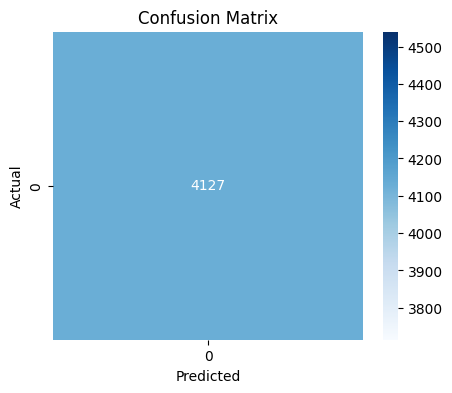

In [65]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [28]:

import shap


C:\Users\TEJASHREE\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [66]:
X_shap = X_test.iloc[:500]

In [68]:
# Create SHAP explainer
explainer = shap.TreeExplainer(rf_model)


In [70]:
# Take a small sample from test set for explanation
#X_shap = X_test[:500]

# Calculate SHAP values
shap_values = explainer.shap_values(X_shap)


In [ ]:
# Convert scaled test data to DataFrame for SHAP
# X_test_scaled_df = pd.DataFrame(
#     X_test,
#     columns=X.columns
# )

# Take a small sample
# X_shap = X_test.iloc[:500]


In [ ]:

# explainer = shap.TreeExplainer(rf_model)

In [ ]:
# shap_values = explainer.shap_values(X_shap)


In [69]:
# Handle SHAP output format
if isinstance(shap_values, list):
    shap_values_to_plot = shap_values[1]  # Fail Soon class
else:
    shap_values_to_plot = shap_values


In [72]:
if shap_values_to_plot.shape[1] == X_shap.shape[1] + 1:
    shap_values_to_plot = shap_values_to_plot[:, :-1]

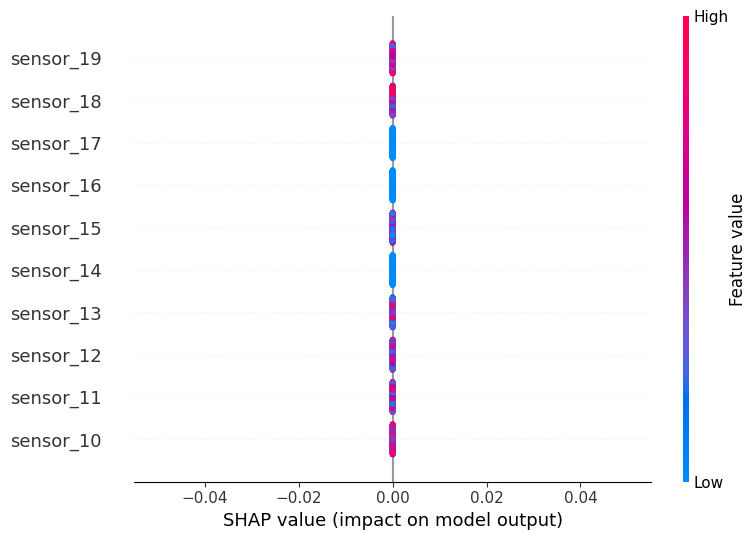

In [74]:
shap.summary_plot(
    shap_values_to_plot,
    X_shap,
    max_display=10
)


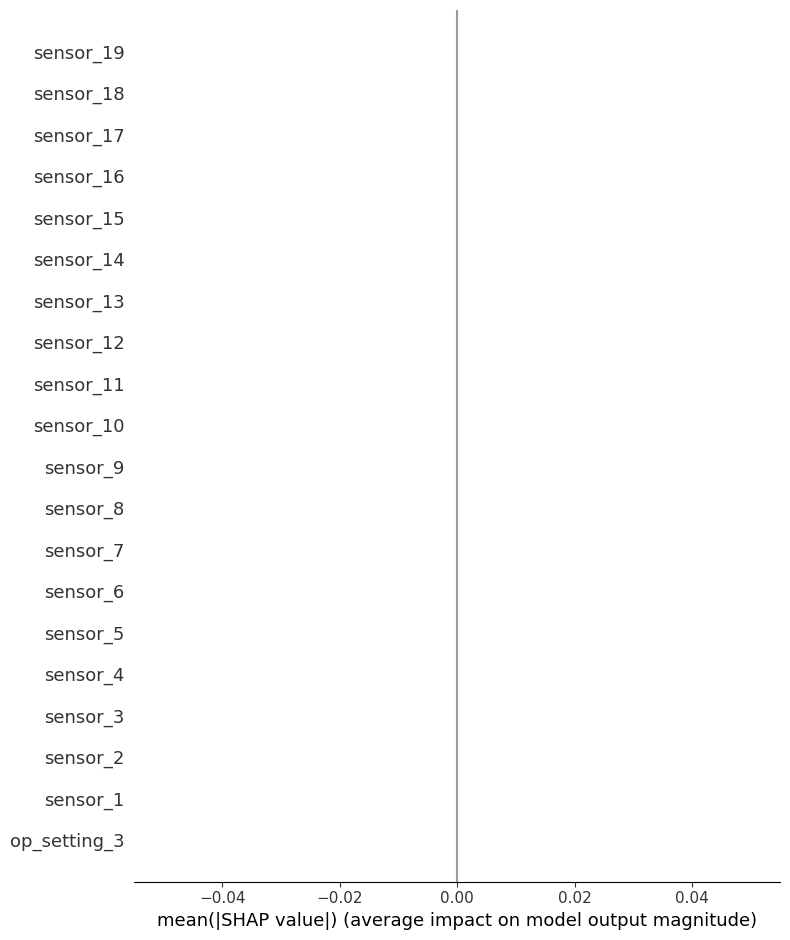

In [75]:
shap.summary_plot(shap_values_to_plot, X_shap, plot_type="bar")
